In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import random


In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [4]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [5]:
# Gather portfolio preferences from user

risk_score = input("""What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
""")

preference_equity = input("""What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
""")


preference_fixed_income = input("""What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
""")


time_period = input("""What's your preferred time duration for investment? Enter a number to indicate the number of years.
""")


investment_value = input("""What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
""")

risk_score = int(risk_score)
preference_equity = int(preference_equity)
preference_fixed_income = int(preference_fixed_income)
time_period = int(time_period)
investment_value = int(investment_value)

What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
 5
What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
 1
What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
 1
What's your preferred time duration for investment? Enter a number to indicate the number of years.
 5
What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
 10000


In [6]:
# Create the list for the required tickers

# equity
tickers_equity_type1 = ["DIA", "DVY", "VNQ"]#dividend income
tickers_equity_type2 = ["QQQ", "VBK", "ARKK"]#capital growth
tickers_equity_type3 = ["SPY", "VXF", "IWM"]#balanced

# income
tickers_income_type1 = ["LQD"]#higher risk
tickers_income_type2 = ["IEI"]#higher quality
tickers_income_type3 = ["AGG"]#mixed

In [7]:
# Risk score needs to be converted to asset weights

weight_risk = risk_score/10 
weight_fixed = 1 - weight_risk 

        
    
# Do we need the below code?????????????????

# equity_investment = investment_value * weight_risk ($700)
# DIA = (1/3)* equity_investment
# DVY = (1/3)* equity_investment
# VNQ = (1/3)* equity_investment


# income_investment = investment_value * weight_fixed ($300)

In [8]:
# Assigns an empty list for tickers to be used for equity. If statement from user input determines how list is populated.

equity_tickers = []

if preference_equity == 1:
    equity_tickers = tickers_equity_type1
    
elif preference_equity == 2:
    equity_tickers = tickers_equity_type2
    
elif preference_equity == 3:
    equity_tickers = tickers_equity_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [9]:
# Assigns an empty list for tickers to be used for fixed income. If statement from user input determines how list is populated.

fixed_income_tickers = []

if preference_fixed_income == 1:
    fixed_income_tickers = tickers_income_type1
    
elif preference_fixed_income == 2:
    fixed_income_tickers = tickers_income_type2
    
elif preference_fixed_income == 3:
    fixed_income_tickers = tickers_income_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [10]:
tickers = equity_tickers + fixed_income_tickers
tickers

['DIA', 'DVY', 'VNQ', 'LQD']

In [11]:
# Determines weights to be applied to each ETF in the portfolio. For this analysis, assumes equity ETFs will be equal weighted.

weight_equity_1 = weight_risk / 3
weight_equity_2 = weight_risk /3
weight_equity_3 = weight_risk / 3
weight_fixed = 1 - weight_equity_1 - weight_equity_2 - weight_equity_3

weights = [weight_equity_1, weight_equity_2, weight_equity_3, weight_fixed]
weights

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.5000000000000001]

In [12]:
# Places portfolio tickers and weights into a dataframe and sorts alphabetically in order to run API call for ticker data

portfolio_df = pd.DataFrame({'tickers': tickers, 'weights': weights})
portfolio_df = portfolio_df.sort_values('tickers')
portfolio_df

,tickers,weights
0,DIA,0.166667
1,DVY,0.166667
3,LQD,0.500000
2,VNQ,0.166667


In [13]:
# recreates tickers list, this time in alphabetical order
tickers = portfolio_df['tickers'].tolist()
tickers

['DIA', 'DVY', 'LQD', 'VNQ']

In [14]:
# recreates weights list, this time, in the same order as the new sorted tickers list
weights = portfolio_df['weights'].tolist()
weights

[0.16666666666666666,
 0.16666666666666666,
 0.5000000000000001,
 0.16666666666666666]

In [15]:
# sets number of trading days for the simulation (time horizon of the investment)
num_trading_days = 252 * time_period

In [16]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Inside the function set the date parameter to the prior business day 
# The start and end data should be 2017-05-01 to 2020-05-01
# Set the parameter tz to "America/New_York", 
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

In [17]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [18]:
# Use the Alpaca get_barset function to gather the price information for each ticker
# Include the function parameters: tickers, timeframe, start, end, and limit
# Be sure to call the df property to ensure that the returned information is set as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Review the first five rows of the resulting DataFrame 
prices_df.head()

DIA                                        DVY  \
                             open    high      low     close   volume   open   
time                                                                           
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042  89.06   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729  88.29   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028  88.80   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907  88.83   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356  90.41   

                                                                   LQD  \
                              high      low   close     volume    open   
time                                                                     
2018-12-31 00:00:00-05:00  89.3099  88.3000  88.950  2673934.0  112.52   
2019-01-02 00:00:00-05:00  89.3300  87.8700  88.970  1164455.0  112.82   
2019-01-03 00:00:00-05:00  89.1800  87.9100  88.280   995745.0  113.00   
2019-01-04 00:00:00-05:00  90.4499  88.4201  90.350  1590662.0  112.88   
2019-01-07 00:00:00-05:00  91.5600  89.9500  90.905  1899922.0  113.39   

                                                                  VNQ  \
                             high      low   close      volume   open   
time                                                                    
2018-12-31 00:00:00-05:00  112.92  112.430  112.87   6653280.0  74.31   
2019-01-02 00:00:00-05:00  113.17  112.780  113.14   7408517.0  73.56   
2019-01-03 00:00:00-05:00  113.30  112.950  113.23  10699301.0  72.77   
2019-01-04 00:00:00-05:00  113.20  112.810  113.19  11586608.0  73.74   
2019-01-07 00:00:00-05:00  113.46  113.145  113.16  15695175.0  74.60   

                                                             
                              high    low   close    volume  
time                                                         
2018-12-31 00:00:00-05:00  74.7200  73.30  74.405  15320211  
2019-01-02 00:00:00-05:00  73.7000  72.53  72.880  10872410  
2019-01-03 00:00:00-05:00  74.5700  72.71  73.430   9963138  
2019-01-04 00:00:00-05:00  75.0200  73.30  74.330   7585079  
2019-01-07 00:00:00-05:00  75.6062  74.40  75.045   7502420

In [19]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# Use an even weight of .33 across all 3 stocks
MC_even_weight = MCSimulation(
    portfolio_data = prices_df,
    weights = weights,
    num_simulation = 500,
    num_trading_days = num_trading_days
)

# Printing the first five rows of the simulation input data
MC_even_weight.portfolio_data.head()

DIA                                      \
                             open    high      low     close   volume   
time                                                                    
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356   

                                          DVY                            ...  \
                          daily_return   open     high      low   close  ...   
time                                                                     ...   
2018-12-31 00:00:00-05:00          NaN  89.06  89.3099  88.3000  88.950  ...   
2019-01-02 00:00:00-05:00     0.005221  88.29  89.3300  87.8700  88.970  ...   
2019-01-03 00:00:00-05:00    -0.024852  88.80  89.1800  87.9100  88.280  ...   
2019-01-04 00:00:00-05:00     0.031032  88.83  90.4499  88.4201  90.350  ...   
2019-01-07 00:00:00-05:00     0.004909  90.41  91.5600  89.9500  90.905  ...   

                               LQD                                     VNQ  \
                               low   close      volume daily_return   open   
time                                                                         
2018-12-31 00:00:00-05:00  112.430  112.87   6653280.0          NaN  74.31   
2019-01-02 00:00:00-05:00  112.780  113.14   7408517.0     0.002392  73.56   
2019-01-03 00:00:00-05:00  112.950  113.23  10699301.0     0.000795  72.77   
2019-01-04 00:00:00-05:00  112.810  113.19  11586608.0    -0.000353  73.74   
2019-01-07 00:00:00-05:00  113.145  113.16  15695175.0    -0.000265  74.60   

                                                                          
                              high    low   close    volume daily_return  
time                                                                      
2018-12-31 00:00:00-05:00  74.7200  73.30  74.405  15320211          NaN  
2019-01-02 00:00:00-05:00  73.7000  72.53  72.880  10872410    -0.020496  
2019-01-03 00:00:00-05:00  74.5700  72.71  73.430   9963138     0.007547  
2019-01-04 00:00:00-05:00  75.0200  73.30  74.330   7585079     0.012257  
2019-01-07 00:00:00-05:00  75.6062  74.40  75.045   7502420     0.009619  

[5 rows x 24 columns]

In [20]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
# Create a new variable for the simulation above
sim_df = MC_even_weight.calc_cumulative_return()
sim_df

C:\Users\mwoji\FinTech-Workspace\Projects\portfolio_optimizer\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001779,0.999673,1.002285,0.987761,0.994010,1.004503,1.005471,1.003816,1.012163,1.009988,...,1.002869,1.000446,0.992656,0.993123,1.004669,1.005750,0.999400,0.993769,0.991274,0.999486
2,1.012475,1.001740,1.000681,0.983441,0.983587,1.002381,1.001972,1.010529,1.010975,1.007236,...,1.011912,1.003234,0.988182,0.995022,0.994849,1.008475,1.000225,1.002326,1.000953,1.002233
3,1.006470,1.008453,1.000138,0.984400,0.989299,0.999539,1.006944,1.011916,1.008336,1.013080,...,1.015034,1.003232,0.988897,0.994872,0.991409,1.011104,1.006454,0.996038,0.993944,1.001071
4,1.006016,1.009278,0.997722,0.979391,0.986025,0.989777,1.009260,1.011118,1.012077,1.011048,...,1.015484,1.009982,0.983983,1.002651,1.000175,1.006214,1.005080,1.000624,0.998344,1.007460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.724925,1.636910,1.271746,2.341645,1.465420,2.143709,1.842652,1.956723,1.509049,1.623567,...,2.535557,2.206096,1.847227,2.130661,1.850638,1.555105,1.805148,1.590381,1.636784,1.977981
1257,1.741264,1.633974,1.279291,2.367571,1.468290,2.138004,1.842283,1.954758,1.512044,1.627858,...,2.542256,2.192412,1.844009,2.123191,1.834185,1.561770,1.801118,1.585839,1.626752,1.967519
1258,1.734291,1.624815,1.273975,2.354119,1.464220,2.137249,1.848477,1.967418,1.519979,1.618237,...,2.528295,2.181218,1.834447,2.135879,1.828014,1.551028,1.809002,1.580894,1.616462,1.964744
1259,1.739807,1.629235,1.271655,2.349613,1.457132,2.133045,1.855163,1.967901,1.519500,1.617442,...,2.522607,2.163987,1.838317,2.102449,1.840003,1.549437,1.801963,1.585602,1.618493,1.969395


In [21]:
# Computes and returns a dataframe for daily price returns of each simulation for each trading day
shift_df = sim_df.shift(-1)
returns_df = (shift_df - sim_df) / sim_df
returns_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.001779,-0.000327,0.002285,-0.012239,-0.005990,0.004503,0.005471,0.003816,0.012163,0.009988,...,0.002869,0.000446,-0.007344,-0.006877,0.004669,0.005750,-0.000600,-0.006231,-0.008726,-0.000514
1,0.010677,0.002068,-0.001600,-0.004373,-0.010486,-0.002113,-0.003480,0.006687,-0.001173,-0.002725,...,0.009017,0.002787,-0.004507,0.001912,-0.009774,0.002710,0.000825,0.008610,0.009764,0.002748
2,-0.005931,0.006702,-0.000543,0.000974,0.005808,-0.002836,0.004962,0.001373,-0.002611,0.005802,...,0.003085,-0.000003,0.000723,-0.000150,-0.003459,0.002607,0.006227,-0.006273,-0.007002,-0.001159
3,-0.000451,0.000818,-0.002415,-0.005088,-0.003309,-0.009766,0.002300,-0.000789,0.003710,-0.002006,...,0.000444,0.006729,-0.004968,0.007819,0.008842,-0.004837,-0.001365,0.004604,0.004427,0.006382
4,-0.000045,0.004822,0.002069,0.003251,0.006727,-0.002302,-0.001494,0.007705,-0.000962,0.000324,...,-0.001931,0.001264,-0.001764,-0.000411,0.000991,-0.010100,0.008930,0.003445,-0.002043,0.000451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.009472,-0.001793,0.005933,0.011072,0.001958,-0.002661,-0.000200,-0.001004,0.001985,0.002643,...,0.002642,-0.006203,-0.001743,-0.003506,-0.008890,0.004286,-0.002232,-0.002856,-0.006129,-0.005289
1257,-0.004004,-0.005606,-0.004156,-0.005682,-0.002772,-0.000353,0.003362,0.006477,0.005248,-0.005910,...,-0.005491,-0.005106,-0.005185,0.005976,-0.003364,-0.006878,0.004377,-0.003118,-0.006326,-0.001411
1258,0.003180,0.002721,-0.001821,-0.001914,-0.004841,-0.001967,0.003617,0.000246,-0.000315,-0.000491,...,-0.002250,-0.007900,0.002110,-0.015652,0.006558,-0.001026,-0.003891,0.002978,0.001257,0.002368
1259,-0.003382,0.004415,-0.006419,0.003573,-0.002717,0.005815,0.005545,0.004855,-0.003545,-0.001413,...,0.000667,-0.015487,0.002319,0.001725,0.004190,-0.005783,0.012130,0.001256,-0.005040,-0.004844


In [22]:
# Computes the standard deviation of returns for each simulation
annual_std_list = returns_df.std() * (252 **0.5)
annual_std_list

0      0.090666
1      0.087884
2      0.090468
3      0.093460
4      0.089715
         ...   
495    0.089121
496    0.091303
497    0.091012
498    0.090287
499    0.089975
Length: 500, dtype: float64

In [23]:
# and then averages the results to come up with an estimated standard deviation of the portfolio
annual_std = annual_std_list.mean()
annual_std

0.09047977763683972

In [24]:
# Repeats this process to come up with an annual return for each simulation
annual_ret_list = returns_df.mean() * 252
annual_ret_list

0      0.114207
1      0.102378
2      0.050869
3      0.175982
4      0.078780
         ...   
495    0.090400
496    0.124378
497    0.096597
498    0.099379
499    0.138651
Length: 500, dtype: float64

In [25]:
# and then averages the results to come up with an estimated return of the portfolio
annual_ret = annual_ret_list.mean()
annual_ret

0.11101378890632217

In [26]:
# Input for estimated income of the portfolio
annual_income = .02

In [27]:
#A function to simulate a random set of returns for a portfolio over a desired time horizon given various parameters
def simulate_return(mean_return, standard_dev, annual_income, simulated_quarters, number_of_simulations, initial_investment):
    
    #quarterly return of the portfolio plus quarterly income. the mean return could be a call to summary statistics and the annual income to a csv.
    quarterly_ret = (mean_return/4) + (annual_income/4)
    
    #quarterly standard deviation of the portfolio. standard deviation could be a call to summary statistics.
    quarterly_stdev = standard_dev / (4**0.5)
    
    #returns a random set of standard deviation multipliers plus the mean return. For example return +/- 1 SD or return +/- (1.65 x Std) to obtain a list of random returns
    quarterly_returns = 1 + np.random.normal(quarterly_ret, quarterly_stdev, (simulated_quarters,number_of_simulations))
    
    #defines the portfolio variable in the same array shape as the previously estimated returns
    portfolio = np.zeros_like(quarterly_returns)
    
    #sets an initial investment for the simulation
    portfolio[0] = initial_investment
    
    #for loop to project out portfolio market value for each simulation
    for t in range (1, simulated_quarters):
        portfolio[t] = (portfolio[t-1]*quarterly_returns[t])
    return pd.DataFrame(portfolio)

In [28]:
simulated_quarters = time_period * 4

<AxesSubplot:>

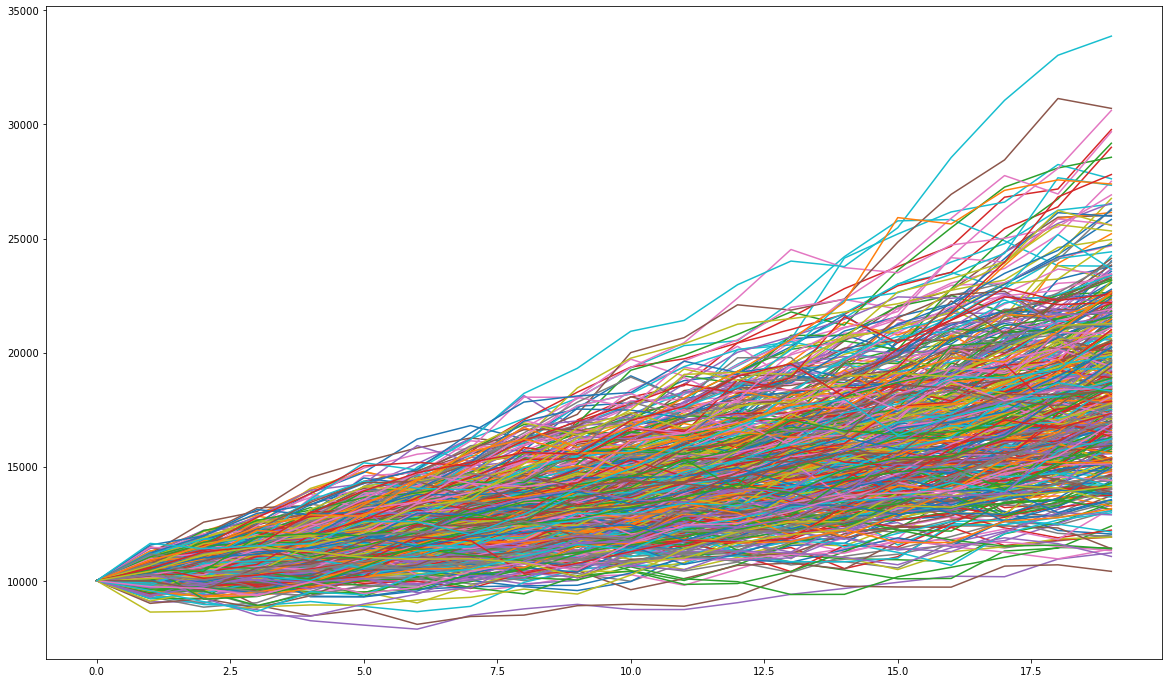

In [29]:
#plot the results. Ideally we could simply use this function to allow easily interchangable parameters 
simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).plot(figsize = (20,12), legend=None)

In [30]:
# Creates a new variable for the end results of the simulation
ending_values = simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).tail(1)

In [31]:
# Organizes ending results into one column
ending_values = ending_values.T
ending_values.columns = ['Ending Values']
ending_values

,Ending Values
0,19094.714987
1,27419.348599
2,18029.433956
3,18727.266107
4,15904.501714
...,...
495,20458.973505
496,15918.174504
497,18554.847234
498,14302.030743


<AxesSubplot:ylabel='Frequency'>

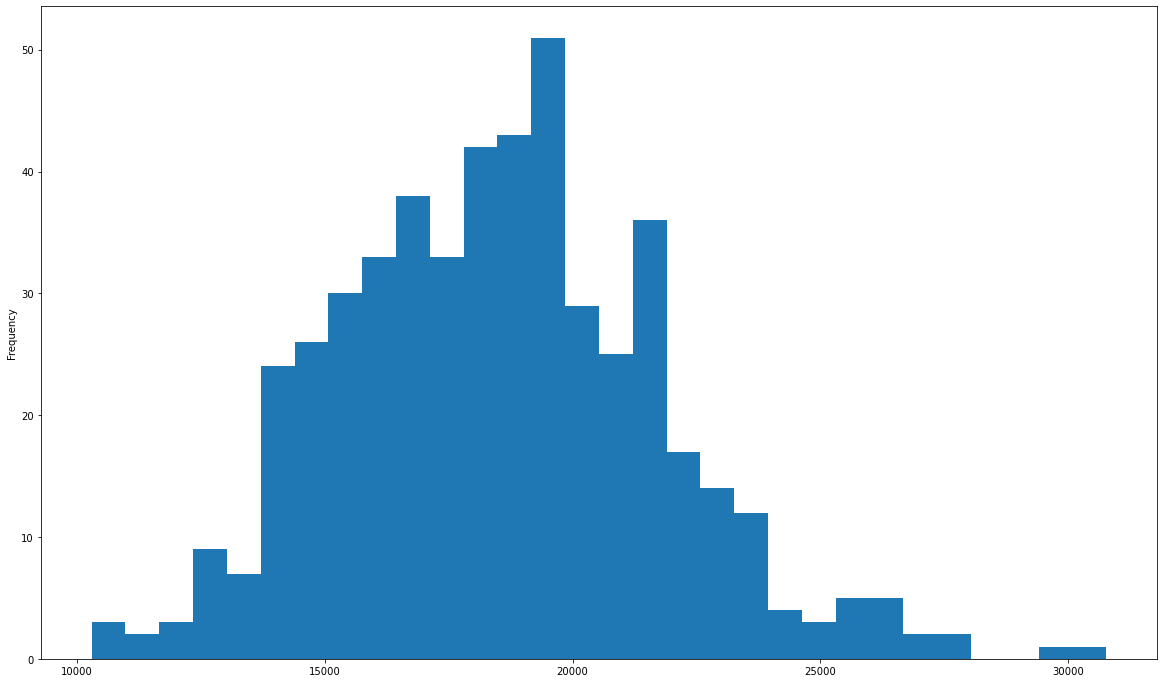

In [32]:
# Plots distribution of ending results
ending_values.plot.hist(bins = 30, figsize = (20,12), legend=None)

In [33]:
# See summary statistics for ending results
ending_values.describe()

,Ending Values
count,500.000000
mean,18526.604970
std,3244.093667
min,10295.233246
25%,16111.059909
50%,18471.554677
75%,20559.340203
max,30771.516838
